# Matrix Factorisation - Linear with Bias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Prepare the data

In [3]:
# Skip date
df = pd.read_csv('/content/combined_data_4.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df['Rating'] = df['Rating'].astype(float)
df


,Cust_Id,Rating
0,13368:,NaN
1,2385003,4.0
2,659432,3.0
3,751812,2.0
4,2625420,2.0
...,...,...
509580,838773,3.0
509581,2052133,3.0
509582,960786,3.0
509583,1764201,5.0


In [4]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [ 1.  1.  1. ... 71. 71. 71.]
Length: 509514


In [5]:
# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
df

-Dataset examples-


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Cust_Id,Rating,Movie_Id
1,2385003,4.0,1
2,659432,3.0,1
3,751812,2.0,1
4,2625420,2.0,1
5,1650301,1.0,1
...,...,...,...
509580,838773,3.0,71
509581,2052133,3.0,71
509582,960786,3.0,71
509583,1764201,5.0,71


In [6]:
df.shape

(509514, 3)

In [7]:
df.dtypes

Cust_Id       int64
Rating      float64
Movie_Id      int64
dtype: object

In [8]:
pip install sklearn

In [9]:
from sklearn.preprocessing import LabelEncoder

In [10]:
def encode_user_item(df, user_col, item_col, rating_col):
    """Function to encode users and items
    
    Params:     
        df (pd.DataFrame): Pandas data frame to be used.
        user_col (string): Name of the user column.
        item_col (string): Name of the item column.
        rating_col (string): Name of the rating column.
        timestamp_col (string): Name of the timestamp column.
    
    Returns: 
        encoded_df (pd.DataFrame): Modifed dataframe with the users and items index
    """
    
    encoded_df = df.copy()
    
    user_encoder = LabelEncoder()
    user_encoder.fit(encoded_df[user_col].values)
    n_users = len(user_encoder.classes_)
    
    item_encoder = LabelEncoder()
    item_encoder.fit(encoded_df[item_col].values)
    n_items = len(item_encoder.classes_)

    encoded_df["USER"] = user_encoder.transform(encoded_df[user_col])
    encoded_df["ITEM"] = item_encoder.transform(encoded_df[item_col])
    
    encoded_df.rename({rating_col: "RATING"}, axis=1, inplace=True)
    
    print("Number of users: ", n_users)
    print("Number of items: ", n_items)
    
    return encoded_df, user_encoder, item_encoder

In [11]:
# Data Encoding
DATA, user_encoder, item_encoder = encode_user_item(df, "Cust_Id", "Movie_Id", "Rating")

Number of users:  205643
Number of items:  71


In [12]:
DATA.head()

,Cust_Id,RATING,Movie_Id,USER,ITEM
1,2385003,4.0,1,185141,0
2,659432,3.0,1,51482,0
3,751812,2.0,1,58625,0
4,2625420,2.0,1,203724,0
5,1650301,1.0,1,128603,0


In [13]:
n_users = DATA.USER.nunique()
n_items = DATA.ITEM.nunique()
n_users, n_items


(205643, 71)

In [14]:
max_rating = DATA.RATING.max()
min_rating = DATA.RATING.min()
min_rating, max_rating

(1.0, 5.0)

In [15]:
def random_split (df, ratios, shuffle=False):
    
    """Function to split pandas DataFrame into train, validation and test
    
    Params:     
        df (pd.DataFrame): Pandas data frame to be split.
        ratios (list of floats): list of ratios for split. The ratios have to sum to 1.
    
    Returns: 
        list: List of pd.DataFrame split by the given specifications.
    """
    seed = 42                  # Set random seed
    if shuffle == True:
        df = df.sample(frac=1)     # Shuffle the data
    samples = df.shape[0]      # Number of samples
    
    # Converts [0.7, 0.2, 0.1] to [0.7, 0.9]
    split_ratio = np.cumsum(ratios).tolist()[:-1] # Get split index
    
    # Get the rounded integer split index
    split_index = [round(x * samples) for x in split_ratio]
    
    # split the data
    splits = np.split(df, split_index)
    
    # Add split index (this makes splitting by group more efficient).
    for i in range(len(ratios)):
        splits[i]["split_index"] = i

    return splits

In [16]:
# Data Splitting
train, test = random_split(DATA, [0.8, 0.2])

In [17]:
train.shape, test.shape

((407611, 6), (101903, 6))

## Explicit Matrix Factorisation 

In [18]:
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot, Add, Lambda, Activation, Reshape
from keras.regularizers import l2
from keras.constraints import non_neg
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

In [19]:
def Explicit_MF_Bias(n_users, n_items, n_factors):
    
    # Item Layer
    item_input = Input(shape=[1], name='Item')
    item_embedding = Embedding(n_items, n_factors, embeddings_regularizer=l2(1e-6), name='ItemEmbedding')(item_input)
    item_vec = Flatten(name='FlattenItemE')(item_embedding)
    
    # Item Bias
    item_bias = Embedding(n_items, 1, embeddings_regularizer=l2(1e-6), name='ItemBias')(item_input)
    item_bias_vec = Flatten(name='FlattenItemBiasE')(item_bias)

    # User Layer
    user_input = Input(shape=[1], name='User')
    user_embedding = Embedding(n_users, n_factors, embeddings_regularizer=l2(1e-6), name='UserEmbedding')(user_input)
    user_vec = Flatten(name='FlattenUserE')(user_embedding)
    
    # User Bias
    user_bias = Embedding(n_users, 1, embeddings_regularizer=l2(1e-6), name='UserBias')(user_input)
    user_bias_vec = Flatten(name='FlattenUserBiasE')(user_bias)

    # Dot Product of Item and User & then Add Bias
    DotProduct = Dot(axes=1, name='DotProduct')([item_vec, user_vec])
    AddBias = Add(name="AddBias")([DotProduct, item_bias_vec, user_bias_vec])
    
    # Scaling for each user
    y = Activation('sigmoid')(AddBias)
    rating_output = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(y)
    
    # Model Creation
    model = Model([user_input, item_input], rating_output)
    
    # Compile Model
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))
    
    return model

In [20]:
n_factors = 50
model = Explicit_MF_Bias(n_users, n_items, n_factors)

In [21]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
ItemEmbedding (Embedding)       (None, 1, 50)        3550        Item[0][0]                       
__________________________________________________________________________________________________
UserEmbedding (Embedding)       (None, 1, 50)        10282150    User[0][0]                       
_______________________________________________________________________________________

### Train the Model

In [22]:
%%time
output = model.fit([train.USER, train.ITEM], train.RATING, batch_size=128,
                                  epochs=2, verbose=1, 
                   validation_data=([test.USER, test.ITEM], test.RATING))

Epoch 1/2


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


3185/3185 [==============================] - 320s 100ms/step - loss: 1.0006 - val_loss: 1.2372
Epoch 2/2
3185/3185 [==============================] - 318s 100ms/step - loss: 0.5901 - val_loss: 1.2418
CPU times: user 18min 11s, sys: 30.6 s, total: 18min 42s
Wall time: 10min 39s


In [23]:
import altair as alt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from keras.preprocessing.image import ImageDataGenerator
        
# Visualise the metrics from the model
def metrics(history):
    df = pd.DataFrame(history)
    df.reset_index()
    df["batch"] = df.index + 1
    df = df.melt("batch", var_name="name")
    df["val"] = df.name.str.startswith("val")
    df["type"] = df["val"]
    df["metrics"] = df["val"]
    df.loc[df.val == False, "type"] = "training"
    df.loc[df.val == True, "type"] = "validation"
    df.loc[df.val == False, "metrics"] = df.name
    df.loc[df.val == True, "metrics"] = df.name.str.split("val_", expand=True)[1]
    df = df.drop(["name", "val"], axis=1)
    
    base = alt.Chart().encode(
        x = "batch:Q",
        y = "value:Q",
        color = "type"
    ).properties(width = 300, height = 300)

    layers = base.mark_circle(size = 50).encode(tooltip = ["batch", "value"]) + base.mark_line()
    chart = layers.facet(column='metrics:N', data=df).resolve_scale(y='independent')    
    
    return chart

In [24]:
metrics(output.history)

alt.FacetChart(...)

### Score the Model

In [25]:
score = model.evaluate([test.USER, test.ITEM], test.RATING, verbose=1)
score

3185/3185 [==============================] - 75s 24ms/step - loss: 1.2418


1.2418330907821655

In [26]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
print(mean_absolute_error(test.RATING, model.predict([test.USER, test.ITEM])))
print(mean_squared_error(test.RATING, model.predict([test.USER, test.ITEM])))

0.8473273029367447
1.2224875484956683


### Prediction & recommendation

In [27]:
def get_embedding(model, name):
    embedding = model.get_layer(name = name).get_weights()[0]
    return embedding

def get_predictions(model, data):
    """
    Get predictions for all user-item combinations
    
    Params:
        data (pandas.DataFrame): DataFrame of entire rating data
        model (Keras.model): Trained keras model
        
    Returns:
        pd.DataFrame: DataFrame of rating predictions for each user and each item
        
    """
    # Create the crossjoin for user-item
    user_item = user_item_crossjoin(data)
    
    # Score for every user-item combination
    user_item["RATING_PRED"] = model.predict([user_item.USER, user_item.ITEM])
    
    return user_item


def user_item_crossjoin(df):
    """
    Get cross-join of all users and items
    
    Args:
        df (pd.DataFrame): Source dataframe.

    Returns:
        pd.DataFrame: Dataframe with crossjoins
    
    """
    
    crossjoin_list = []
    for user in df.USER.unique():
        for item in df.ITEM.unique():
            crossjoin_list.append([user, item])

    cross_join_df = pd.DataFrame(data=crossjoin_list, columns=["USER", "ITEM"])
    
    return cross_join_df
    

def filter_by(df, filter_by_df, filter_by_cols):
    """From the input DataFrame (df), remove the records whose target column (filter_by_cols) values are
    exist in the filter-by DataFrame (filter_by_df)

    Args:
        df (pd.DataFrame): Source dataframe.
        filter_by_df (pd.DataFrame): Filter dataframe.
        filter_by_cols (iterable of str): Filter columns.

    Returns:
        pd.DataFrame: Dataframe filtered by filter_by_df on filter_by_cols
    """

    return df.loc[
        ~df.set_index(filter_by_cols).index.isin(
            filter_by_df.set_index(filter_by_cols).index
        )
    ]


def get_top_k_items(df, col_user, col_rating, k=10):
    """Get the top k items for each user.

    Params:
        dataframe (pandas.DataFrame): DataFrame of rating data
        col_user (str): column name for user
        col_rating (str): column name for rating
        k (int): number of items for each user

    Returns:
        pd.DataFrame: DataFrame of top k items for each user, sorted by `col_user` and `rank`
    """
    # Sort dataframe by col_user and (top k) col_rating
    top_k_items = (
        df.groupby(col_user, as_index=False)
        .apply(lambda x: x.nlargest(k, col_rating))
        .reset_index(drop=True)
    )
    # Add ranks
    top_k_items["rank"] = top_k_items.groupby(col_user, sort=False).cumcount() + 1
    return top_k_items


def recommend_topk(model, data, train, k=5):
    
    """
    Params:
        data (pandas.DataFrame): DataFrame of entire rating data
        train (pandas.DataFrame): DataFrame of train rating data
        k (int): number of items for each user

    Returns:
        pd.DataFrame: DataFrame of top k items for each user, sorted by `col_user` and `rank`
    
    """
    
    # Get predictions for all user-item combination
    all_predictions = get_predictions(model, data)
    
    # Handle Missing Values
    all_predictions.fillna(0, inplace=True)
    
    # Filter already seen items
    all_predictions_unseen = filter_by(all_predictions, train, ["USER", "ITEM"])
    
    recommend_topk_df = get_top_k_items(all_predictions_unseen, "USER", "RATING_PRED", k=5)
    
    return recommend_topk_df

In [28]:
item_embedding = get_embedding(model, "ItemEmbedding")
user_embedding = get_embedding(model, "UserEmbedding")

In [30]:
%%time
predictions = get_predictions(model, DATA)

CPU times: user 12min 55s, sys: 39.6 s, total: 13min 35s
Wall time: 12min 30s


In [31]:
%%time
# Recommendation for TopK
ranking_topk = recommend_topk(model, DATA, train, k=5)

CPU times: user 19min 43s, sys: 48.4 s, total: 20min 32s
Wall time: 19min 29s


### Get Similar Items

In [41]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL


def get_similar(embedding, k):
    model_similar_items = NearestNeighbors(n_neighbors=k, algorithm="ball_tree").fit(embedding)
    distances, indices = model_similar_items.kneighbors(embedding)
    
    return distances, indices



def show_similar(item_index, item_similar_indices, item_encoder):
        
    s = item_similar_indices[item_index]
    movie_ids = item_encoder.inverse_transform(s)

    images = []
    for movie_id in movie_ids:
        img_path = '/content/' + str(movie_id) + '.jpg'
        images.append(mpimg.imread(img_path))

    plt.figure(figsize=(20,10))
    columns = 5
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.axis('off')
        plt.imshow(image)

In [38]:
%%time
item_distances, item_similar_indices = get_similar(item_embedding, 5)

CPU times: user 3.29 ms, sys: 15 µs, total: 3.31 ms
Wall time: 3.53 ms


In [39]:
item_similar_indices

array([[ 0,  8, 31, 37,  3],
       [ 1, 37, 35, 31, 33],
       [ 2, 17,  8, 11, 18],
       [ 3, 31, 37, 28, 33],
       [ 4, 37, 33, 42, 53],
       [ 5, 31, 35,  3,  8],
       [ 6, 31,  3,  5, 35],
       [ 7,  8, 26, 33, 39],
       [ 8, 37, 31, 26, 28],
       [ 9, 36, 12,  6,  5],
       [10,  6, 12,  9, 45],
       [11, 17, 18, 27, 26],
       [12,  9,  6, 36, 31],
       [13,  8,  1, 33, 37],
       [14,  3, 21, 37,  4],
       [15, 39, 19,  1, 33],
       [16, 28, 39, 19, 27],
       [17, 37, 28,  8, 31],
       [18,  8, 31, 37, 27],
       [19,  8, 39, 28, 27],
       [20,  9, 12, 36, 45],
       [21,  3, 47, 42, 33],
       [22, 37, 38, 33, 28],
       [23, 38, 22, 17, 32],
       [24, 28, 19, 39, 16],
       [25,  1, 35,  3, 31],
       [26, 37,  8, 31, 28],
       [27, 31, 37, 28,  8],
       [28, 37, 33, 31, 42],
       [29, 47, 37, 53, 56],
       [30,  2, 17, 11, 38],
       [31, 35, 37,  8, 27],
       [32,  1,  8, 18, 31],
       [33, 37, 42, 28,  3],
       [34, 22

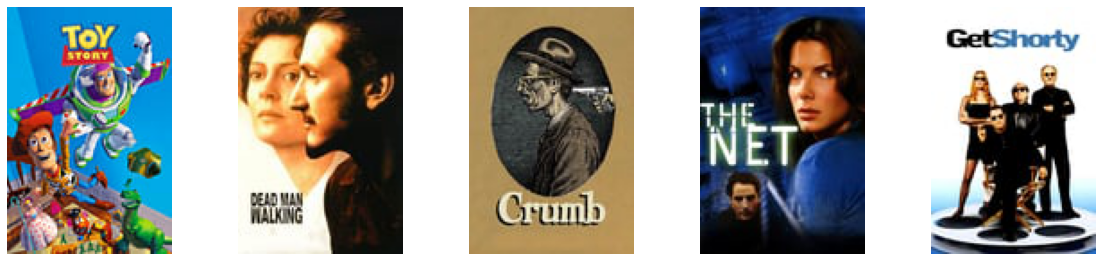

In [46]:
show_similar(0, item_similar_indices, item_encoder) 